In [1]:
import numpy as np
import torch
from utils_zh.data_process import data_process
from utils_zh.faster_rcnn import load_model

In [2]:
def create_model():

    test_loader = data_process(
        image_dir='../data/VOC2012/animal_images_test',
        annotation_dir='../data/VOC2012/animal_annotations_test',
    )
    # 获取测试文件的路径

    model = load_model()
    device = torch.device('cpu')
    model.to(device)    
    model.load_state_dict(torch.load('../model/model.pt',map_location=device))
    print("Completed loading model")
    # 加载模型并转换为cpu模式

    return model,device,test_loader

In [3]:
def evaluate(outputs, targets, score_threshold=0.5):
    total_predicted = 0
    total_correct = 0
    animal_classes = [1, 2, 3, 4, 5, 6]
    # 定义动物类别的索引列表 并去除background

    for output, target in zip(outputs, targets):

        pred_boxes = output['boxes'].cpu().numpy()
        pred_labels = output['labels'].cpu().numpy()
        pred_scores = output['scores'].cpu().numpy()
        # 将测试结果的张量转换为numpy数组 方便后续处理

        high_conf_indices = pred_scores > score_threshold
        pred_boxes = pred_boxes[high_conf_indices]
        pred_labels = pred_labels[high_conf_indices]
        pred_scores = pred_scores[high_conf_indices]
        # 如果预测结果大于设定的阈值的话 则标记这个分数 否则直接删除

        true_boxes = target['boxes'].cpu().numpy()
        true_labels = target['labels'].cpu().numpy()
        animal_indices = np.isin(true_labels, animal_classes)
        true_boxes = true_boxes[animal_indices]
        true_labels = true_labels[animal_indices]
        # 提取真实值的边界框和标签
        # 并通过isin函数分别判断该标签是否在animal_classses中
        # 如果存在的话则把该为标记为true正常保留 否则在后面判断的时候直接删除

        print(f"Predicted boxes: {pred_boxes}, Predicted labels: {pred_labels}, Scores: {pred_scores}")
        print(f"True boxes: {true_boxes}, True labels: {true_labels}")

        total_predicted += len(pred_labels)
        total_correct += sum(pred == true for pred, true in zip(pred_labels, true_labels))
        # 计算预测值和真实值的标签的数量

    accuracy = total_correct / total_predicted
    print(f"Accuracy: {accuracy:.4f}")

In [4]:
def test(model,device,test_loader):
    model.eval()
    with torch.no_grad():
    # 设置为评估模式并禁用梯度计算
    
        for images, targets in test_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # 将待处理的数据移动到定义好的设备上

            outputs = model(images)
            evaluate(outputs, targets)
            # 获取评估结果并调用evaluate函数计算准确率

In [5]:
from matplotlib import pyplot as plt

def generate_image(image_tensor, boxes, labels, scores, threshold=0.5):

    animal_classes = ['background', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep']
    
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    # 因为pytorch张量格式通常为(C,H,W) 也就是通道数 高度 宽度
    # 需要转换为matplotlib的格式(H,W,C)
    
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image_np)
    # 创建一个12x9的包含子图的窗口并显示

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            # 如果预测可信度大于阈值 那么就解包边界框

            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
            # 创建边界框对象 并选择不填充内部颜色 只显示2像素的边框

            ax.text(xmin, ymin, f'{animal_classes[label]}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12, color='black')
            # 添加一串文本 并定义起始位置为右上角
            # 通过animal_classes找到对应的文本并结合预测可信度一起显示
            # 设置背景框颜色为黄色 透明度为0.5 并设置字体大小和文字颜色

    plt.axis('off')
    plt.show()
    # 关闭坐标轴并显示图像

In [9]:
def image_show():
    model, device, test_loader = create_model()
    model.eval()
    with torch.no_grad():
    # 使用评估模式并禁用梯度计算
    
        for images, _ in test_loader:
            images = list(image.to(device) for image in images)
            
            outputs = model(images)
            # 返回预测结果
            
            image_tensor = images[0]
            output = outputs[0]
            # 将图片和预测结果取出

            boxes = output['boxes'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            # 并全部转换为numpy形式

            generate_image(image_tensor, boxes, labels, scores)
            break
            # 传入generate_image函数创建图像 并break掉因为只需要一张图片进行显示

Completed loading model


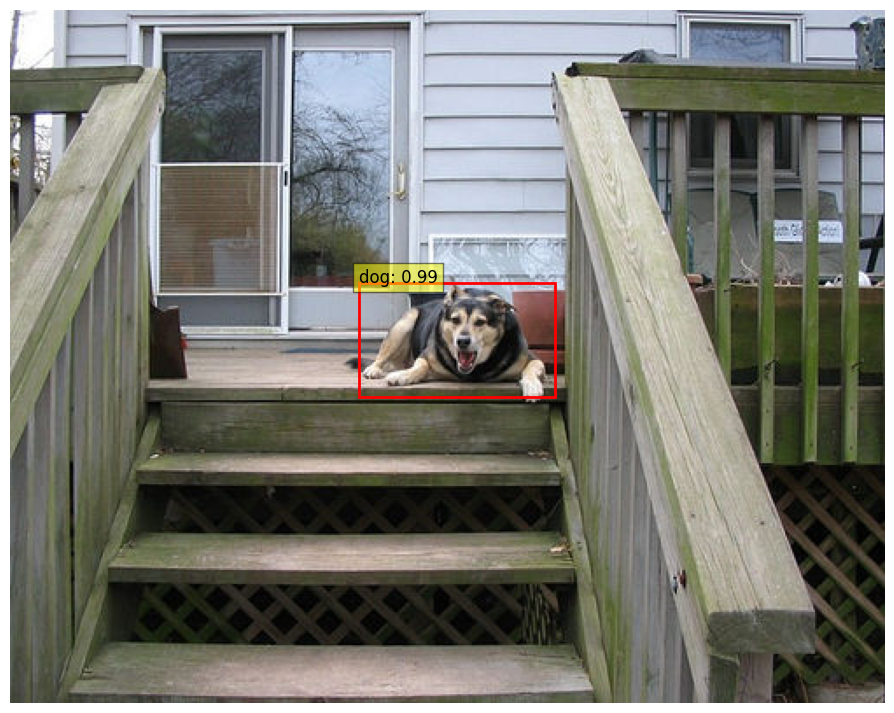

In [11]:
image_show()